# CUNEF MUCD 2022/2023
## Machine Learning
## Análisis de Fraude¶

# Autores:
Gozde Yazganoglu

Irma Sanchez

La interpretabilidad es muy importante debido a las regulaciones de Protección de Datos europeas. Los clientes pueden pedir una justificación para que se hayan tomado las decisiones, los inspectores pueden inspeccionar nuestro modelo de trabajo y, si no podemos expresarnos correctamente, nuestra empresa se enfrenta a enormes tarifas de penalización.

En este caso particular, el fraude ocurre muy raramente. Seguro que nuestro modelo debería detectarlo. Ya hemos mencionado al principio que si no detectamos, nuestra empresa podría enfrentar enormes pérdidas. ¿Y si detectamos mal? Esto también es malo para nuestra credibilidad. 
Si los clientes no pueden recibir su efectivo porque no recibimos su dinero en un momento, son camino del país, por ejemplo (me sucedió una vez, retiré mi dinero en varias transacciones y el banco ha cancelado mi tarjeta de débito mientras estoy en otro país). Si los clientes se quejan de esto y documentan sus pérdidas, es posible que el banco deba cubrirlas.

# Cargando los datos y pipes necessarios

In [1]:
# Manipulacion
import pandas as pd
import numpy as np

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

# Modelos y operaciones 
import sklearn

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# El XGBoost
from sklearn.ensemble import GradientBoostingClassifier 

# Evaluación de modelos
from sklearn import metrics # Evaluación de modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#regex
import re

#matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Cargar modelos
import pickle 

# Shap
import shap


# Ocultar warnings
import warnings
warnings.filterwarnings('ignore')
from aux_func import cargar_modelo

In [2]:
xtrain = pd.read_parquet("../data/processed/xtrain.parquet")
ytrain = pd.read_parquet("../data/processed/ytrain.parquet")
xtest = pd.read_parquet("../data/processed/xtest.parquet")
ytest = pd.read_parquet("../data/processed/ytest.parquet")
df= pd.read_parquet('../data/processed/dataset_payments_fraud_processed.parquet')

xtest.rename(columns={
    'type_0.0':'type_0', 'type_1.0':'type_1','type_2.0':'type_2', 'type_3.0':'type_3', 'type_4.0':'type_4',
    'gender_0.0':'gender_0', 'gender_1.0':'gender_1','gender_2.0':'gender_2',
    'device_0.0':'device_0', 'device_1.0':'device_1','device_2.0':'device_2', 'device_3.0':'device_3',
    'race_0.0':'race_0', 'race_1.0':'race_1','race_2.0':'race_2', 'race_3.0':'race_3',
    'zone_0.0':'zone_0', 'zone_1.0':'zone_1','zone_2.0':'zone_2', 'zone_3.0':'zone_3'
    }, inplace=True)

In [3]:
preprocessor = cargar_modelo('../models/preprocessor.pickle')

In [4]:
cols=[
    'step','amount','connection_time','oldbalanceOrg','age', 'newbalanceOrig',
    'user_number','user_connections','security_alert','oldbalanceDest','newbalanceDest',
    'type_0', 'type_1','type_2','type_3', 'type_4',
    'gender_0', 'gender_1','gender_2',
    'device_0', 'device_1','device_2','device_3',
    'race_0', 'race_1','race_2', 'race_3',
    'zone_0', 'zone_1','zone_2', 'zone_3',
]

   

# Interpretabilidad de Random Forest


In [5]:
with open('../models/RandomForest_optimizado.pickle', 'rb') as f:
    clf = pickle.load(f)

clf.best_params_


{'clasificador__class_weight': 'balanced',
 'clasificador__criterion': 'gini',
 'clasificador__max_depth': 8,
 'clasificador__max_features': 'sqrt',
 'clasificador__n_estimators': 500}

In [6]:
# Generamos predicciones
ypred = clf.predict(xtest)
ypred_proba = clf.predict_proba(xtest)

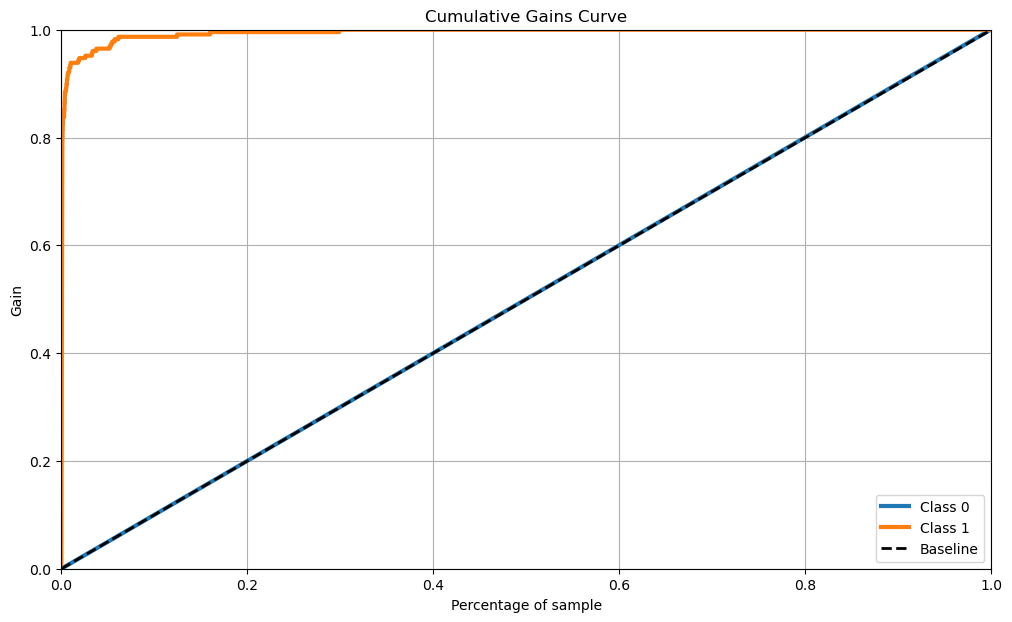

In [7]:
# Gain curve (curva de ganancia acumulada)
skplt.metrics.plot_cumulative_gain(ytest, ypred_proba, figsize=(12, 7));

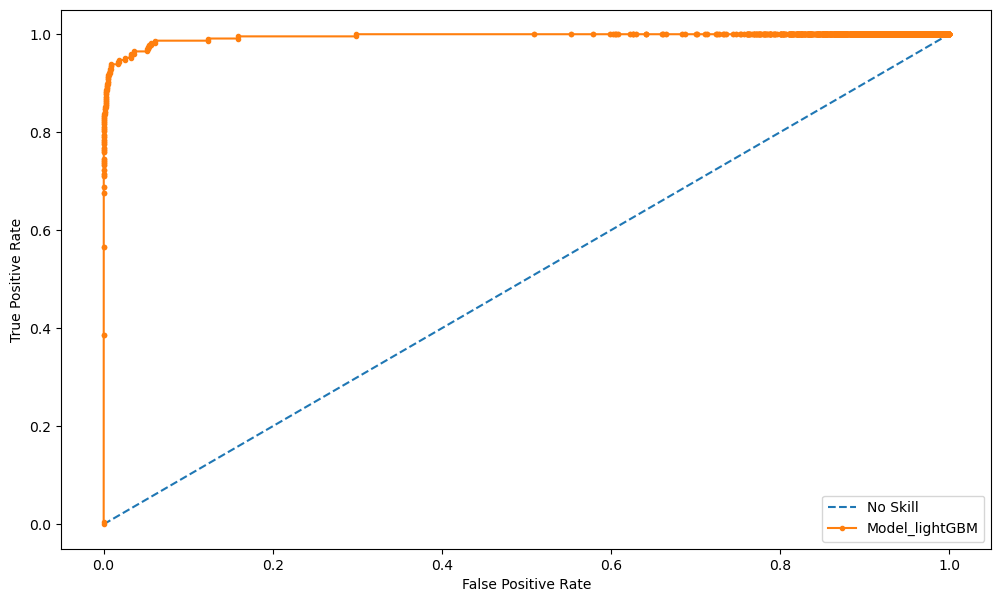

In [8]:
 # keep probabilities for the positive outcome only
matplotlib.rcParams['figure.figsize'] = (12, 7)
yhat = ypred_proba[:, 1]
    # calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)
    # plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label="Model_lightGBM")
    # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
    # show the plot
plt.show()

### Importancía de los Variables

Transformamos los datos como utilizemos.

In [11]:
preprocessor = cargar_modelo('../models/preprocessor.pickle')

In [12]:
cols=[
    'step','amount','connection_time','oldbalanceOrg','age', 'newbalanceOrig',
    'user_number','user_connections','security_alert','oldbalanceDest','newbalanceDest',
    'type_0', 'type_1','type_2','type_3', 'type_4',
    'gender_0', 'gender_1','gender_2',
    'device_0', 'device_1','device_2','device_3',
    'race_0', 'race_1','race_2', 'race_3',
    'zone_0', 'zone_1','zone_2', 'zone_3',
]



xtest = pd.DataFrame(clf.best_estimator_.named_steps['preprocessor'].transform(xtest), columns=cols)
datos_importancia_variables = clf.best_estimator_._final_estimator.feature_importances_

datos_importancia_variables = clf.best_estimator_._final_estimator.feature_importances_

importancia_variables = sorted(
                              list(zip(xtest.columns,
                                       datos_importancia_variables)),
    
    key=lambda tupla: tupla[1],
    reverse=True)

importancia_variables = pd.DataFrame(importancia_variables)
importancia_variables.rename(columns={ 0: 'Variable',  1: 'Importancia'}, inplace=True)

KeyError: 'preprocessor'

In [13]:
plt.figure(figsize=(12, 7))

sns.barplot(x='Importancia',
            y='Variable', 
            data=importancia_variables, 
            color='red')

plt.title('Importancia de las variables');

NameError: name 'importancia_variables' is not defined

<Figure size 1200x700 with 0 Axes>

Según grafico de importancía, nuestro modelo lightGBM cantidad es mas importante en desicion. Como esperamos sexo, razo no son muy importantes. Pero es interesante encontrar alerta de seguiridad y dispositivo, no son variables muy importantes en LightGBM model.

In [18]:
shap.initjs()
model = clf.best_estimator_.named_steps['clasificador']
explainer = shap.TreeExplainer(model)

In [17]:
shap_values = explainer.shap_values(xtest)

ValueError: could not convert string to float: 'CASH_OUT'

In [19]:
with open('../models/shap_values.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

NameError: name 'shap_values' is not defined

In [31]:
# Para no tener que ejecutar
with open('../models/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [1]:
# una sola linea, explicada
shap.force_plot(explainer.expected_value[0], shap_values[1][401], xtest.iloc[401,:])

NameError: name 'shap' is not defined

In [33]:
shap.force_plot(explainer.expected_value[0], shap_values[1][165], xtest.iloc[165,:])

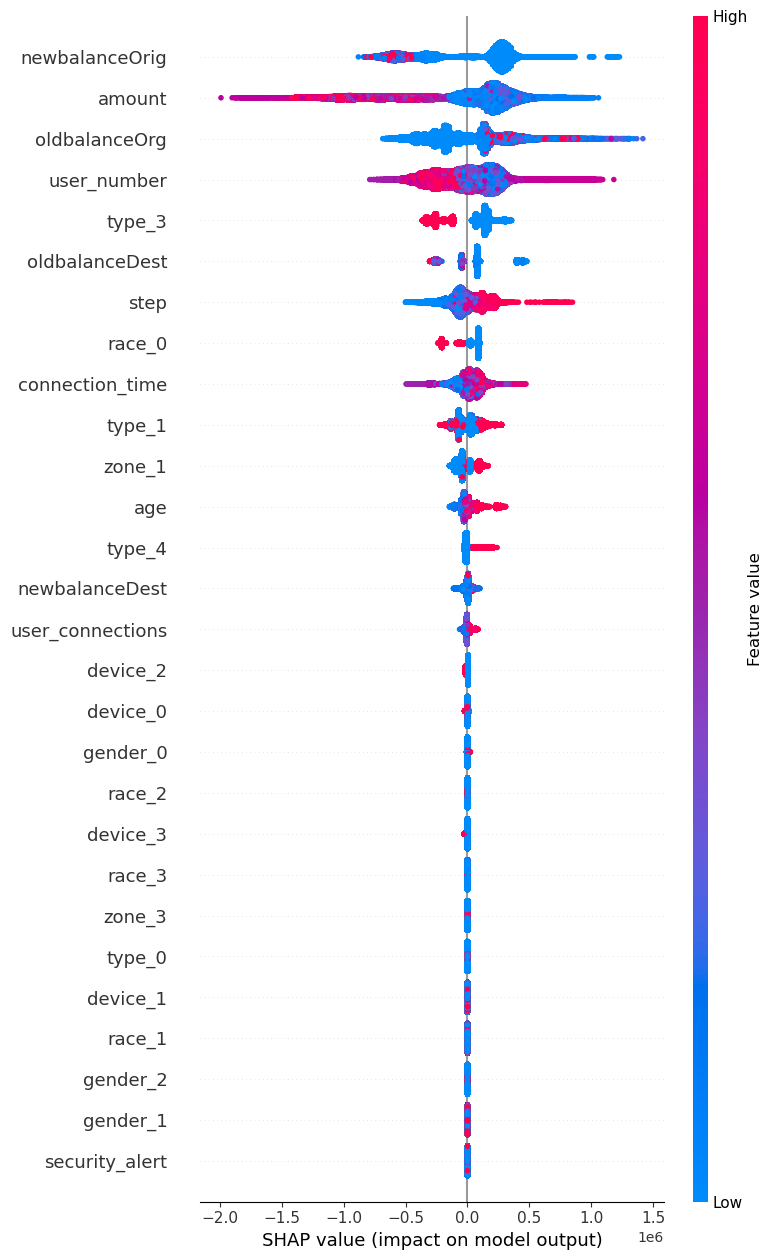

In [34]:
shap.summary_plot(shap_values[1], features=xtest, max_display=28)

Los valores de shap nos enseña que balancias de cuentas cuando tienen más valores de Shap y tienen poco efecto. Numero de personas conectando a misma red tiene mas efecto en mas valores. Valores de cantidad tiene poco efecto cuanto estan mayor y mas efecto cuando estan pocos.

In [35]:
# Para no tener que ejecutar
with open('../models/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [36]:
base_value = explainer.expected_value

In [37]:
shap.force_plot(explainer.expected_value[0], shap_values[1][401], xtest.iloc[401,:])